# Hourly Energy Consumption Playground Notebook

In this notebook I aim to predict the energy consumption for a specific region based on historical time-series data. The dataset contains energy usage (measured in megawatts), and through this analysis I aim to develop a model that can forecast future consumption patterns. This project serves as practice in time-series forecasting, which is a crucial skill for providing trend insights and requires a distinct approach compared to non-time-series data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from dateutil.easter import easter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

%load_ext jupyter_black

In [2]:
df = pd.read_csv("AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [3]:
# Let's see the date range
print("Start Date: ", df["Datetime"].min())
print(" ")
print("End Date: ", df["Datetime"].max())

Start Date:  2004-10-01 01:00:00
 
End Date:  2018-08-03 00:00:00


In [4]:
df.shape

(121273, 2)

In [5]:
# Reindex
df = df.set_index("Datetime")
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


<Axes: xlabel='Datetime'>

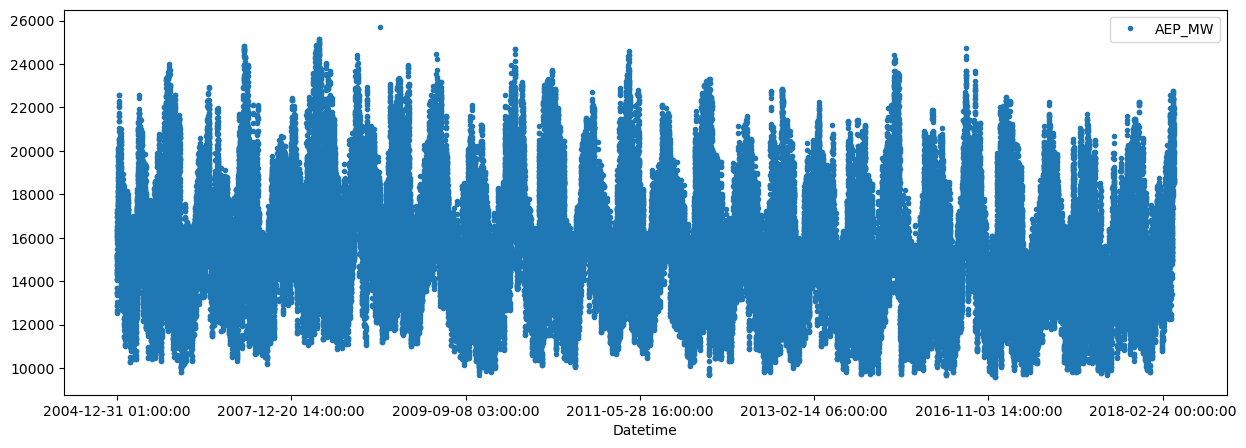

In [6]:
df.plot(style=".", figsize=(15, 5))

In [7]:
# Right now the Datetime dtype is "object"
# In order to continue, we want to convert it to "datetime"
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [8]:
# The date is an object. Want to turn it into datetime
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

<Axes: xlabel='Datetime'>

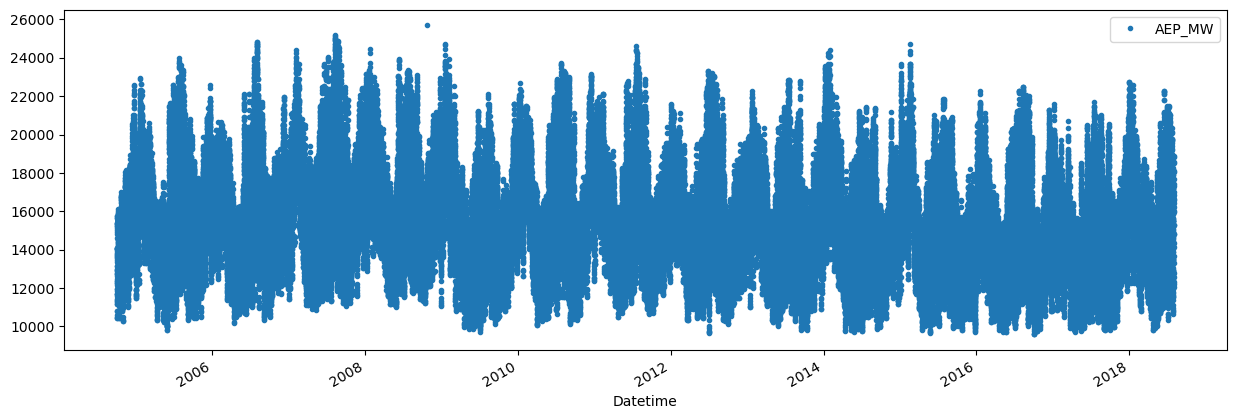

In [9]:
# Replot same plot from above since the y-axis should look cleaner now
df.plot(style=".", figsize=(15, 5))

<Axes: title={'center': 'One Week Data Segment'}, xlabel='Datetime'>

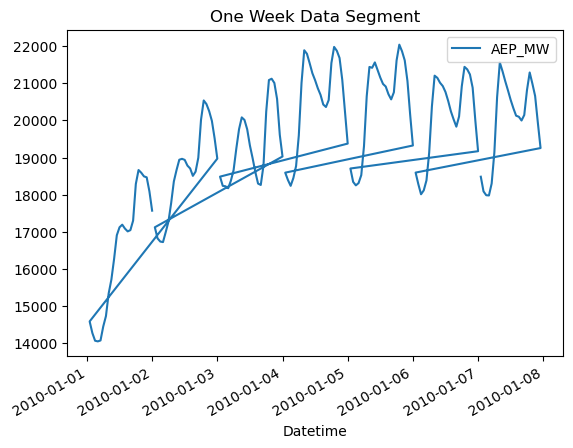

In [10]:
# Plot just one week so we can see the trend on a smaller scale
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    title="One Week Data Segment"
)

### Check For Outliers

<Axes: ylabel='Frequency'>

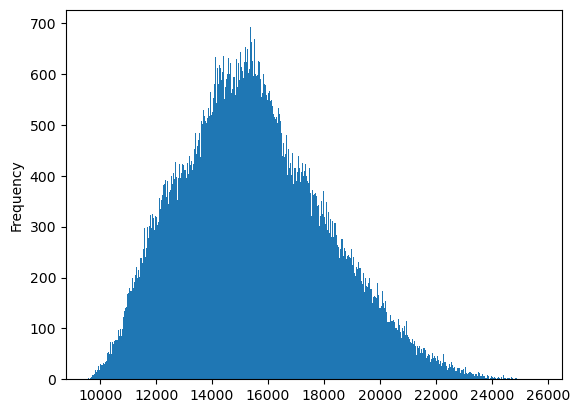

In [11]:
df["AEP_MW"].plot(kind="hist", bins=500)

<Axes: xlabel='Datetime'>

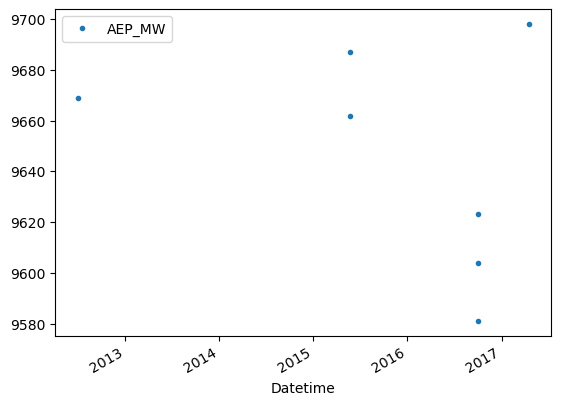

In [12]:
df.query("AEP_MW < 9_700").plot(style=".")

In [13]:
print("Highest Usage: ", df["AEP_MW"].nlargest(10))
print(" ")
print("Lowest Usage: ", df["AEP_MW"].nsmallest(10))

Highest Usage:  Datetime
2008-10-20 14:00:00    25695.0
2007-08-08 15:00:00    25164.0
2007-08-08 17:00:00    25140.0
2007-08-08 16:00:00    25056.0
2007-08-09 17:00:00    25035.0
2007-08-09 16:00:00    24978.0
2007-08-08 14:00:00    24941.0
2007-08-09 15:00:00    24911.0
2007-08-08 18:00:00    24878.0
2007-08-23 17:00:00    24862.0
Name: AEP_MW, dtype: float64
 
Lowest Usage:  Datetime
2016-10-02 05:00:00    9581.0
2016-10-02 06:00:00    9604.0
2016-10-02 04:00:00    9623.0
2015-05-24 05:00:00    9662.0
2012-06-30 05:00:00    9669.0
2015-05-24 04:00:00    9687.0
2017-04-16 05:00:00    9698.0
2009-07-04 07:00:00    9701.0
2014-05-25 05:00:00    9707.0
2015-12-25 04:00:00    9708.0
Name: AEP_MW, dtype: float64


<Axes: xlabel='Datetime'>

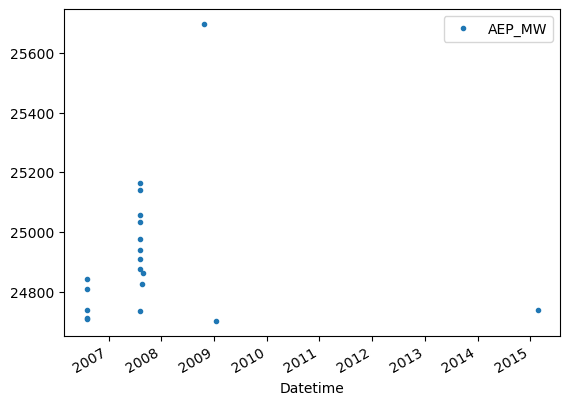

In [14]:
df.query("AEP_MW > 24_700").plot(style=".")

There don't seem to be too many outliers in either direction, but I can still get rid of the few very high and low points

In [15]:
df = df.query("AEP_MW > 9_700 and AEP_MW < 24_700").copy()

<Axes: ylabel='Frequency'>

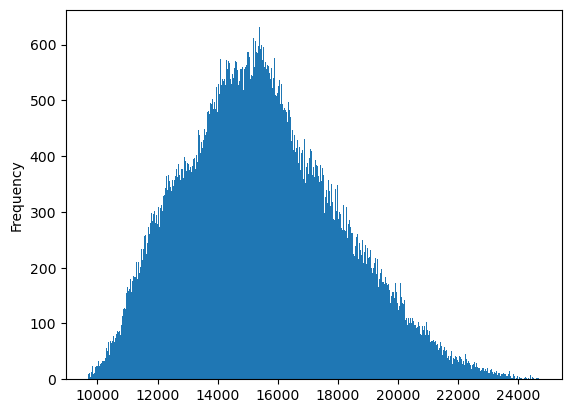

In [16]:
df["AEP_MW"].plot(kind="hist", bins=500)

### How far in the future do we want to/can predict?

Before we continue, it is important to know how far into the future we want to predict. The closer our prediction is to the last Datetime that we have, the more accurate it will be; the further into the future we try to predict, the more difficult it becomes.

### Feature Creation

We want to extract some more features from the datetime so that we can have a more accurate pattern recognition. The initial features (such as "hour", "day_of_week", ..., "day_of_year") are probably the most important ones, followed by the holidays. In order to fully capture the energy usage during the "party holidays", I also included the nearest weekends to that holiday to count as the day itself. However I realize that this is an overkill, and the accuracy does drop a bit with the addition of these weekends. If this was a model that I planned on using to make predictions, I would remove these additional days from the calculated features, nut considering that this is a practice problem, I feel like the consideration is interesting enough in theory so I will leave them in.

**Note:** <br/>
Monday = 0 <br/>
Tuesday = 1 <br/>
Wednesday = 2 <br/>
Thursday = 3 <br/>
Friday = 4 <br/>
Saturday = 5 <br/>
Sunday = 6

In [17]:
def feature_extraction(df):
    """
    Create new features from datetime, including regular intervals and special holidays.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day_of_year"] = df.index.dayofyear
    df["day"] = df.index.day

    # Create regular holiday features
    df["new_year"] = ((df["day"] == 1) & (df["month"] == 1)).astype(int)
    df["christmas"] = ((df["month"] == 12) & (df["day"] == 25)).astype(int)
    df["halloween"] = ((df["month"] == 10) & (df["day"] == 31)).astype(int)
    df["fourth_of_july"] = ((df["month"] == 7) & (df["day"] == 4)).astype(int)

    # Find nearest Friday and Saturday to Halloween, 4th of July, and New Years, since this is
    # when these holidays are most likely to be celebrated if the holiday itself doesn't fall
    # on a Friday or Saturday
    for holiday, col_name in [
        ("Halloween", "halloween"),
        ("4th of July", "fourth_of_july"),
        ("New Year", "new_year"),
    ]:
        holiday_dates = df[df[col_name] == 1].index
        for date in holiday_dates:
            if date.weekday() not in [
                4,
                5,
            ]:  # Check if the holidays fall on Friday (4) or Saturday(5)
                nearest_friday = date + pd.DateOffset(days=(4 - date.weekday()) % 7)
                nearest_saturday = nearest_friday + pd.DateOffset(days=1)

                if nearest_friday in df.index:
                    df.loc[nearest_friday, col_name] = 1
                if nearest_saturday in df.index:
                    df.loc[nearest_saturday, col_name] = 1

    # Calculate Thanksgiving as the fourth Thursday of November
    df["thanksgiving"] = (
        (df["month"] == 11)
        & (df["day_of_week"] == 3)
        & (df["day"] >= 22)
        & (df["day"] <= 28)
    ).astype(int)

    # Easter varies per year, so we will use a library
    df["easter_date"] = df["year"].apply(lambda year: easter(year))
    df["easter"] = (df.index.date == df["easter_date"]).astype(int)

    # Drop helper column since we don't actually need it in the data
    df.drop(columns=["easter_date"], inplace=True)

    return df

In [18]:
df = feature_extraction(df)
df.head()

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,day,new_year,christmas,halloween,fourth_of_july,thanksgiving,easter
Datetime,,,,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,0,0,0,0,0,0
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,0,0,0,0,0,0
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,0,0,0,0,0,0
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,0,0,0,0,0,0
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,0,0,0,0,0,0


Text(0.5, 1.0, 'Usage by Hour')

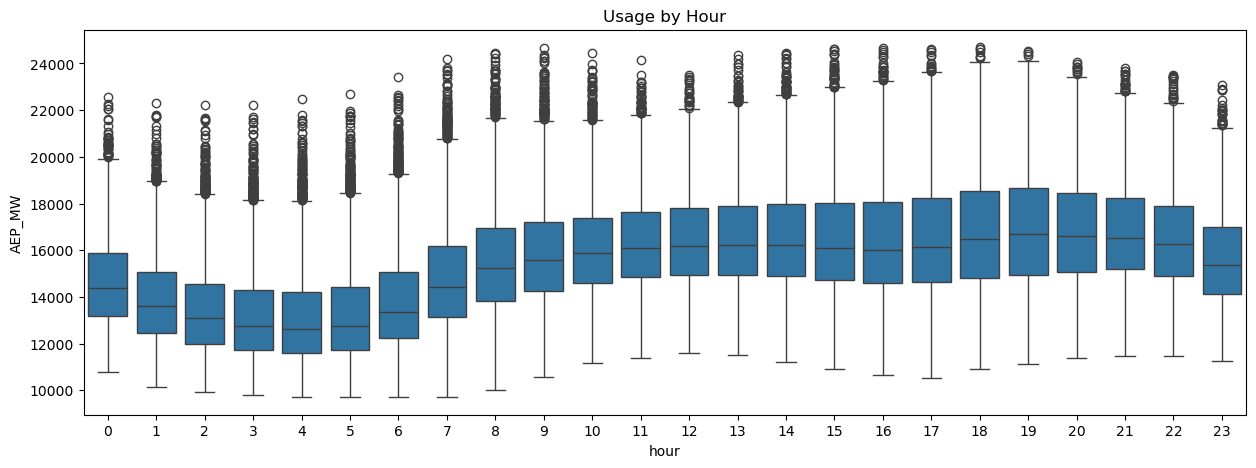

In [19]:
# Now that we extracted specific features, we can check out some more specific usage patterns
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="hour", y="AEP_MW")
ax.set_title("Usage by Hour")

Text(0.5, 1.0, 'Usage by Month')

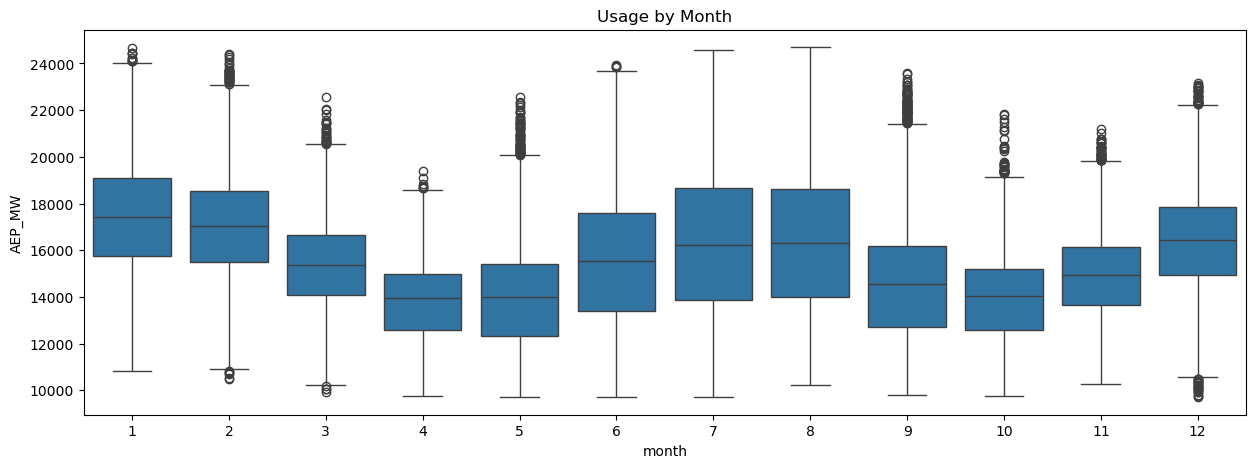

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="month", y="AEP_MW")
ax.set_title("Usage by Month")

Text(0.5, 1.0, 'Usage by Quarter')

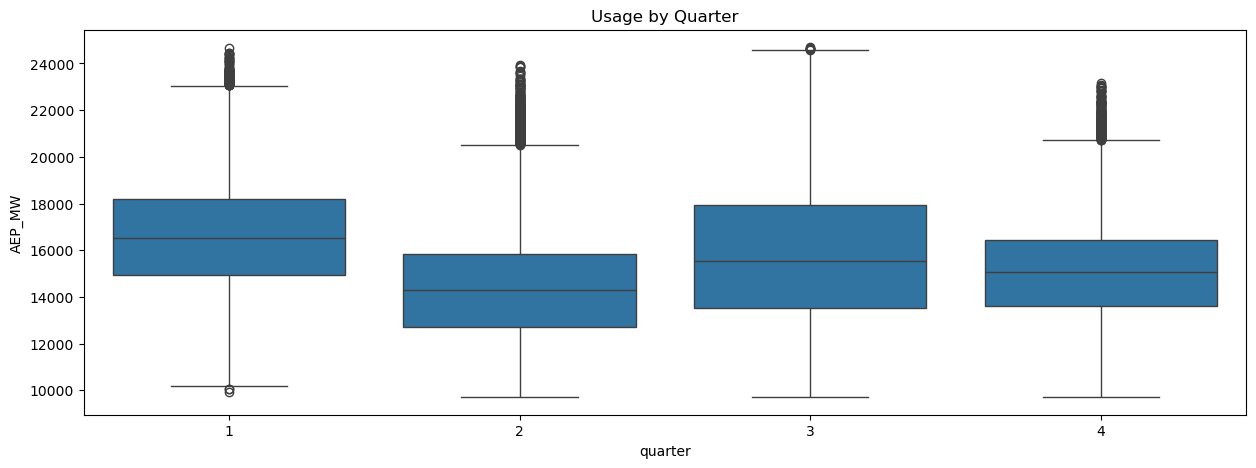

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x="quarter", y="AEP_MW")
ax.set_title("Usage by Quarter")

From the above graphs we can see that the usage peapeaks during winter and summer seasons (most likely during cooling and heating), and dips in between. There usage by quarter shows a more zoomed out picture of this trend.

### Lag Features

How it works: Lag Features look back into the past by some number of days and use the target value for that many days in the past as the new feature that gets fed into the model.

In [22]:
# Create a dictionary which we will use for mapping the lag features onto the data frame
target_map = df["AEP_MW"].to_dict()

In [23]:
def create_lag(df):
    # Will used 364 instead of 365 since 364 is divisible by 7, and is nicer when it comes to mapping
    # out days of the week
    df["lag_one_year"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag_two_years"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag_three_years"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df


df = create_lag(df)

In [24]:
df.tail()

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,day,new_year,christmas,halloween,fourth_of_july,thanksgiving,easter,lag_one_year,lag_two_years,lag_three_years
Datetime,,,,,,,,,,,,,,,,,
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,1,0,0,0,0,0,14832.0,18928.0,20189.0
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,1,0,0,0,0,0,14621.0,18789.0,19953.0
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,1,0,0,0,0,0,14153.0,18402.0,19329.0
2018-01-01 23:00:00,20415.0,23,0,1,1,2018,1,1,1,0,0,0,0,0,13500.0,17657.0,18736.0
2018-01-02 00:00:00,19993.0,0,1,1,1,2018,2,2,0,0,0,0,0,0,12841.0,16894.0,17962.0


### Train/Test Split Using Cross Validation

We can now start getting ready for training. Since time series data is order dependent, the train/test split can't be randomized like it would be for non time-series data. This means that our 80/20 split has to happen chronologically along the Datetime.

In [25]:
# Test size is set this way because we have hourly energy consumption and we want to predict into the future by 1 year
# So 24 hours, times 365 days
# The "gap" is the gap between each training and validation set that I'm splitting on each time.
# I want one day between when the training test ends and validation set begins.
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365, gap=24)
df = df.sort_index()

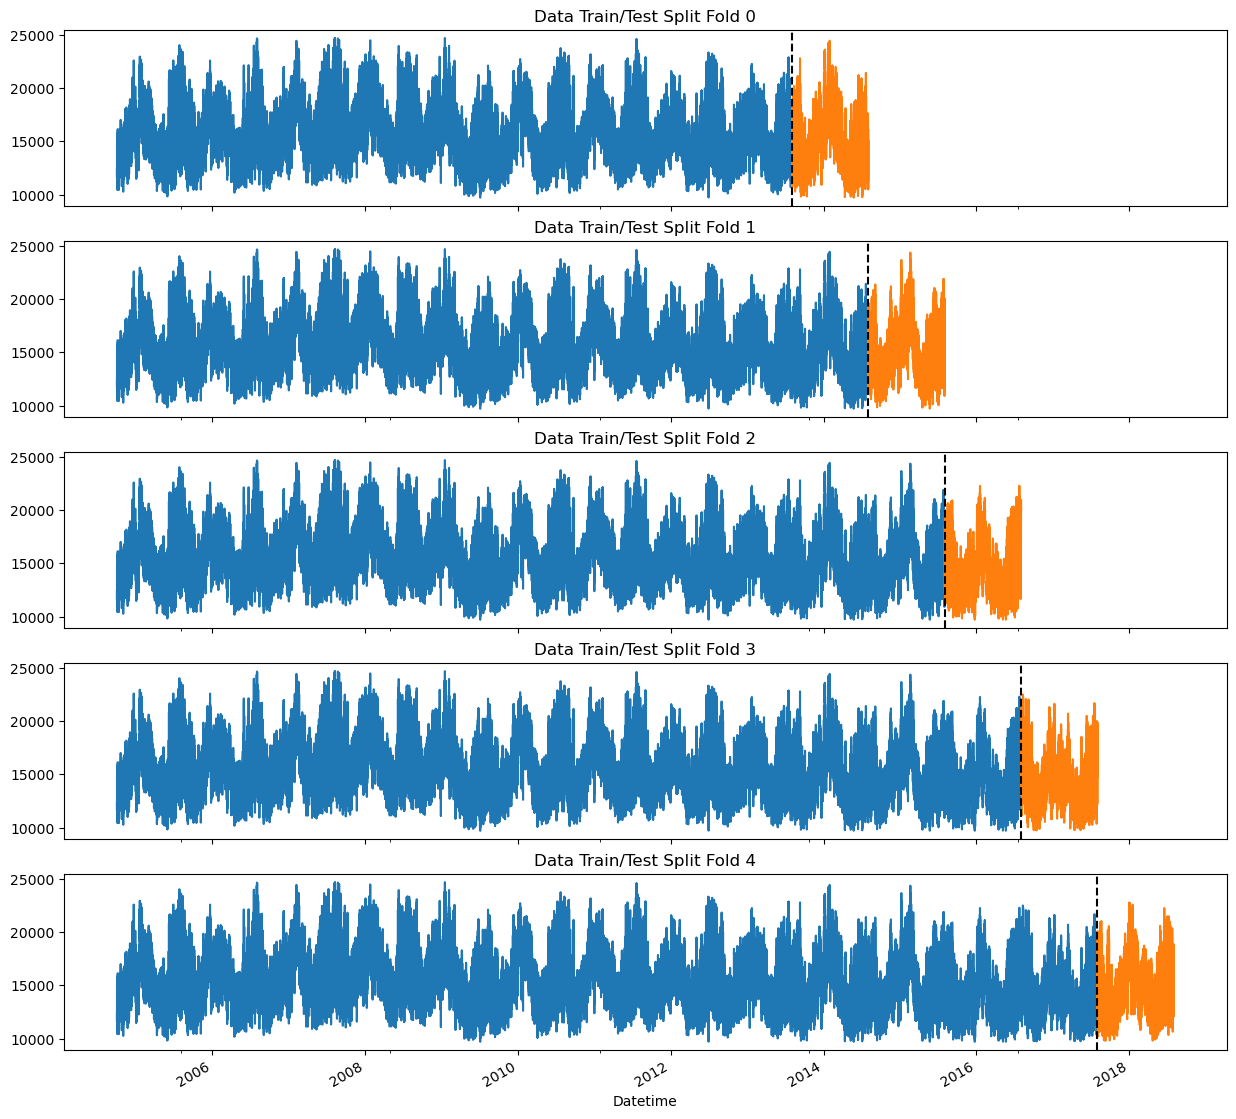

In [26]:
# Visualizing the split so we can see how each fold works
# We can see that we have one year for each validation set in each fold
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15, 15))

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["AEP_MW"].plot(
        ax=axs[fold], label="Training Set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["AEP_MW"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

In [27]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = feature_extraction(train)
    test = feature_extraction(test)

    FEATURES = [
        "hour",
        "day_of_week",
        # "quarter",
        "month",
        "year",
        "day_of_year",
        "day",
        "christmas",
        # "halloween",
        # "fourth_of_july",
        "thanksgiving",
        # "easter",
        # "new_year",
        "lag_one_year",
        "lag_two_years",
        "lag_three_years",
    ]
    TARGET = ["AEP_MW"]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:linear",
        max_depth=3,
        learning_rate=0.01,
    )
    reg.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15895.74612	validation_1-rmse:15264.46454
[100]	validation_0-rmse:6030.20616	validation_1-rmse:5641.05815
[200]	validation_0-rmse:2654.01442	validation_1-rmse:2428.84538


/home/miko/anaconda3/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:50:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:1708.59421	validation_1-rmse:1645.62739
[400]	validation_0-rmse:1488.62229	validation_1-rmse:1554.18828
[437]	validation_0-rmse:1459.68582	validation_1-rmse:1555.83250
[0]	validation_0-rmse:15833.27469	validation_1-rmse:15220.82334
[100]	validation_0-rmse:6006.94817	validation_1-rmse:5713.28336
[200]	validation_0-rmse:2645.15903	validation_1-rmse:2503.76236


/home/miko/anaconda3/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:1707.64612	validation_1-rmse:1612.79313
[400]	validation_0-rmse:1501.16210	validation_1-rmse:1450.69644
[500]	validation_0-rmse:1441.98499	validation_1-rmse:1425.85356
[600]	validation_0-rmse:1410.54422	validation_1-rmse:1421.27613
[700]	validation_0-rmse:1392.39653	validation_1-rmse:1420.32216
[761]	validation_0-rmse:1382.39014	validation_1-rmse:1420.97023
[0]	validation_0-rmse:15777.08500	validation_1-rmse:14549.29030
[100]	validation_0-rmse:5984.59874	validation_1-rmse:5100.54533
[200]	validation_0-rmse:2635.03967	validation_1-rmse:2054.58902


/home/miko/anaconda3/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:01] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[300]	validation_0-rmse:1703.34557	validation_1-rmse:1507.76275
[372]	validation_0-rmse:1529.92409	validation_1-rmse:1518.26764
[0]	validation_0-rmse:15677.36377	validation_1-rmse:14636.18148
[100]	validation_0-rmse:5949.55270	validation_1-rmse:5464.36865


/home/miko/anaconda3/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2627.12707	validation_1-rmse:2470.27745
[300]	validation_0-rmse:1706.72341	validation_1-rmse:1784.53979
[400]	validation_0-rmse:1506.19191	validation_1-rmse:1665.68042
[500]	validation_0-rmse:1452.31789	validation_1-rmse:1649.14505
[583]	validation_0-rmse:1430.71194	validation_1-rmse:1651.74368
[0]	validation_0-rmse:15599.09407	validation_1-rmse:15012.54853
[100]	validation_0-rmse:5924.12861	validation_1-rmse:5861.02847


/home/miko/anaconda3/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [22:51:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2625.92064	validation_1-rmse:2773.91363
[300]	validation_0-rmse:1717.31583	validation_1-rmse:1901.89211
[400]	validation_0-rmse:1512.60036	validation_1-rmse:1713.81299
[500]	validation_0-rmse:1456.56242	validation_1-rmse:1688.20262
[541]	validation_0-rmse:1443.99444	validation_1-rmse:1690.41385


In [28]:
# Now we can see the scores for all of the 5 folds
scores

[1553.8807326956874,
 1419.5594352100304,
 1496.4155123448368,
 1647.30789428063,
 1687.499886461858]

In [29]:
# Makes more sense to see the mean of all of the scores
print("Mean score for all 5 folds: ", np.mean(scores).round(2))

Mean score for all 5 folds:  1560.93


Aside from hyperparameter tuning, we can also check out the features we used and possibly remove some that are not contributing to the model and are potentially creating noise

In [30]:
reg.feature_importances_

array([0.0758066 , 0.04343595, 0.01300965, 0.0294594 , 0.03236393,
       0.01352789, 0.01088762, 0.00907369, 0.51654375, 0.12461475,
       0.13127682], dtype=float32)

In [31]:
# Let's make the feature importance look a bit nicer.
# The above isn't too abrasive to look at, but can get confusing since there are no names
# next to the values
feature_importance = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance_ranking"],
)

feature_importance.sort_values(by="importance_ranking")

,importance_ranking
thanksgiving,0.009074
christmas,0.010888
month,0.013010
day,0.013528
year,0.029459
day_of_year,0.032364
day_of_week,0.043436
hour,0.075807
lag_two_years,0.124615
lag_three_years,0.131277


Mean score for all 5 folds with all features included: 1561.25 <br/>
Mean score for all 5 folds with "quarter", "halloween", "easter", "fourth_of_july" and "new_year" removed: 1560.16 <br/>

This improvement is minor and not worth writing home over

In [32]:
# In order to see the predictions next to all the training data, we will merge the two
test["prediction"] = y_pred
df_merged = df.merge(test["prediction"], how="left", left_index=True, right_index=True)
df_merged.tail()

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,day,new_year,christmas,halloween,fourth_of_july,thanksgiving,easter,lag_one_year,lag_two_years,lag_three_years,prediction
Datetime,,,,,,,,,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,0,0,0,0,0,0,18705.0,20140.0,16078.0,17567.210938
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,0,0,0,0,0,0,18108.0,19616.0,15908.0,17465.025391
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,0,0,0,0,0,0,17544.0,19246.0,15783.0,17327.142578
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,0,0,0,0,0,0,16262.0,17943.0,14808.0,16642.417969
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,0,0,0,0,0,0,15045.0,16491.0,13669.0,14424.438477


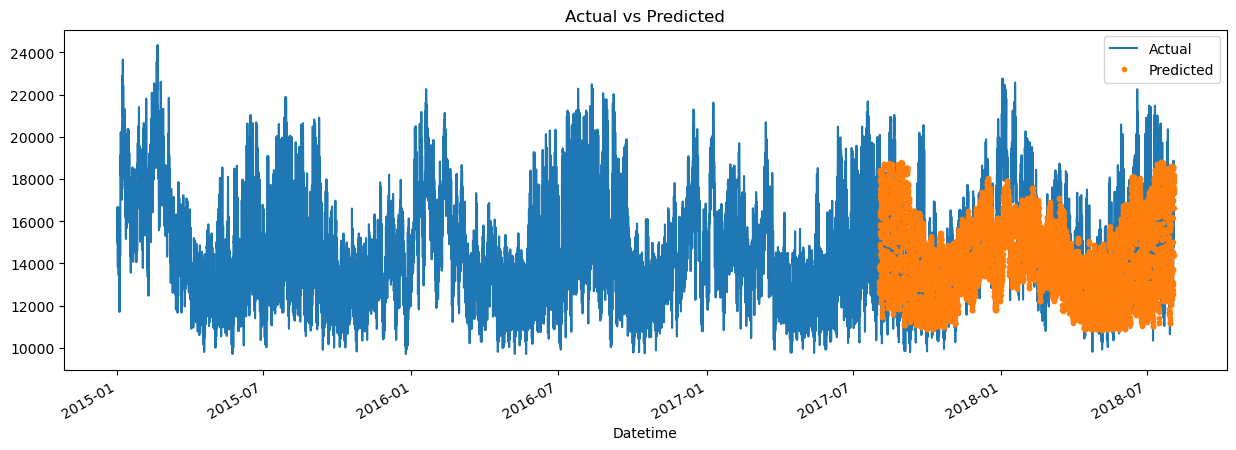

In [33]:
# Only want to look at the graph from 2015 and up, since most of the left side of the graph is
# irrelevant in terms of our prediction
ax = df[df.index > "2015-01-01"]["AEP_MW"].plot(figsize=(15, 5))
df_merged["prediction"].plot(ax=ax, style=".")
plt.legend(["Actual", "Predicted"])
ax.set_title("Actual vs Predicted")
plt.show()

The graphs shows the mode's accuracy compared to the actual wattage usage for the 2016 - 2018 time period. We can see that while certain high and low points weren't predicted accurately, the general trend was captured relatively well

In [34]:
# Worst predicted days
test["error"] = np.abs(test[TARGET]["AEP_MW"] - test["prediction"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=False).head()

date
2018-01-02    5838.121948
2017-12-31    5030.116048
2018-01-01    5028.620239
2018-01-03    4865.988810
2018-01-17    4859.480550
Name: error, dtype: float64

In [35]:
# Best predicted days
test["error"] = np.abs(test[TARGET]["AEP_MW"] - test["prediction"])
test["date"] = test.index.date
test.groupby(["date"])["error"].mean().sort_values(ascending=True).head()

date
2018-04-23    143.684448
2018-06-22    161.475993
2018-02-11    216.142537
2017-10-25    216.433757
2017-12-22    220.988281
Name: error, dtype: float64

### Use Everything We Did Above To Actually Predict The Future

In [36]:
# TODO